This notebook demonstrates how to import the SHMS dataset, process it, and visualize the individual wire hits with Matplotlib.

# Initialization

In [1]:
import uproot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input, Reshape, MaxPooling2D, Conv2D, Dense, Flatten
from tensorflow.python.keras.optimizers import Adam

from pdc import particle_drift_chamber as PDC
import shms_helpers as shms

In [2]:
# Set Matplotlib drawing environment to enable interactive 2D/3D plots
%matplotlib notebook

In [3]:
# Open ROOT file
file = uproot.open('/volatile/hallc/comm2017/mkjones/ROOTfiles/shms_coin_replay_production_all_4019_100000.root')
tree = file['T']

# Set data key prefixes so we don't have to type them every time
h = 'P.dc.hits.'
g = 'P.dc.gtrack.'

# Data Visualization

Some preliminary data processing

In [4]:
# Convert the data into a format which is easier to use
h_tracks = shms.collate(tree[h + 'plane'], tree[h + 'time'], tree[h + 'wirenum'], validate=False)

# Split hits into two lists, one for each drift chamber
h_tracks_1 = [np.asarray([hit for hit in track if hit[0] < 7]) for track in h_tracks]
h_tracks_2 = [np.asarray([hit for hit in track if hit[0] > 6]) for track in h_tracks]


# Convert the data into a format which is easier to use
g_tracks = shms.collate(tree[g + 'plane'], tree[g + 'time'], tree[g + 'wirenum'], validate=False)

# Split hits into two lists, one for each drift chamber
g_tracks_1 = [np.asarray([hit for hit in track if hit[0] < 7]) for track in g_tracks]
g_tracks_2 = [np.asarray([hit for hit in track if hit[0] > 6]) for track in g_tracks]

Example usage demonstrating functionality of `hit_to_2d()`

<IPython.core.display.Javascript object>


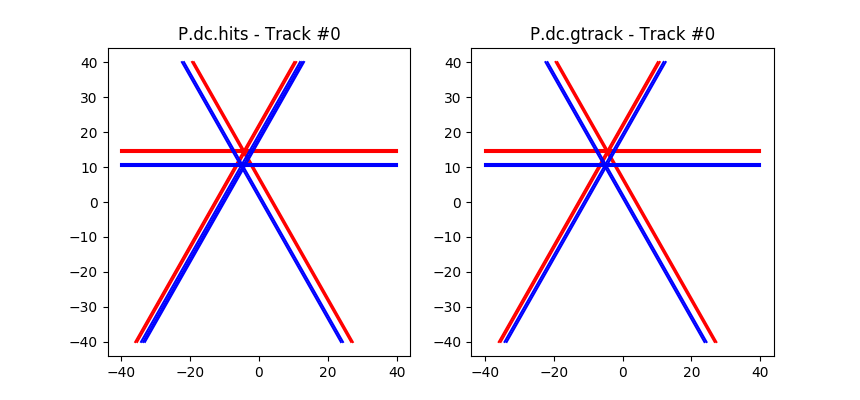

In [5]:
t = 0  # change this value to plot different tracks

fig_dim = 4  # size of figures
fig = plt.figure( figsize=(2.15 * fig_dim, fig_dim) )

ax1 = plt.subplot(121)
plt.title(h[:-1]  + ' - Track #' + str(t))
for hit in h_tracks_2[t]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'r')
for hit in h_tracks_1[t]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'b')

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)  # sharex/sharey make subplots pan/zoom together
plt.title(g[:-1]  + ' - Track #' + str(t))
for hit in g_tracks_2[t]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'r')
for hit in g_tracks_1[t]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'b')

plt.show()

Example usage of `hit_to_3d()`

<IPython.core.display.Javascript object>


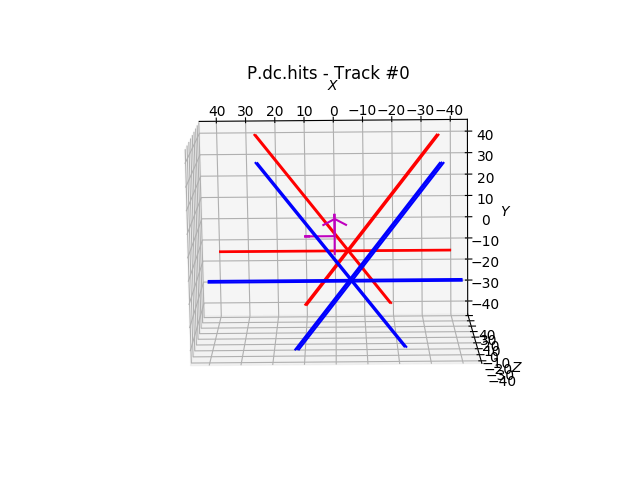

In [6]:
# In this example, we (ab)use the quiver() function to draw a bunch of 3D lines which we get from hit_to_3d()

t = 0  # change this value to plot different tracks

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title(h[:-1] + ' - Track #' + str(t))
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')

# Plot PDC 1 wire hits
for hit in h_tracks_1[t]:
    wire = shms.hit_to_3d(hit)
    x, y, z = wire[0]
    u, v, w = wire[1]
    ax.quiver(x,y,z, u,v,w, color='b', arrow_length_ratio=0.0)
    # Add small vectors at tips of existing ones to make Matplotlib scale the plotting volume correctly
    x, y, z = (i+j for (i,j) in zip(wire[0], wire[1]))
    u, v, w = (0.001, 0.001, 0.001)
    ax.quiver(x,y,z, u,v,w, color='b', arrow_length_ratio=0.0)

# Plot PDC 2 wire hits
for hit in h_tracks_2[t]:
    wire = shms.hit_to_3d(hit)
    x, y, z = wire[0]
    u, v, w = wire[1]
    ax.quiver(x,y,z, u,v,w, color='r', arrow_length_ratio=0.0)
    # Add small vectors at tips of existing ones to make Matplotlib scale the plotting volume correctly
    x, y, z = (i+j for (i,j) in zip(wire[0], wire[1]))
    u, v, w = (0.001, 0.001, 0.001)
    ax.quiver(x,y,z, u,v,w, color='r', arrow_length_ratio=0.0)

# Show beam position/direction vector
# Last entries in x,...,w arrays create small vector so Matplotlib scales volume correctly
x = [0, 0, 0, 0]
y = [0, 0, 0, 0]
z = [0, 0, -40, 40]
u = [10, 0, 0, 0.001]
v = [0, 10, 0, 0.001]
w = [0, 0, 80, 0.001]
ax.quiver(x,y,z, u,v,w, color='m', arrow_length_ratio=0.2)

plt.show()

# Ideas

Illustration of `shear` and `half_plane` options in `hit_to_2d()`. Might this be a useful visualization for convolution kernel design? (It might also be useless...)

<IPython.core.display.Javascript object>


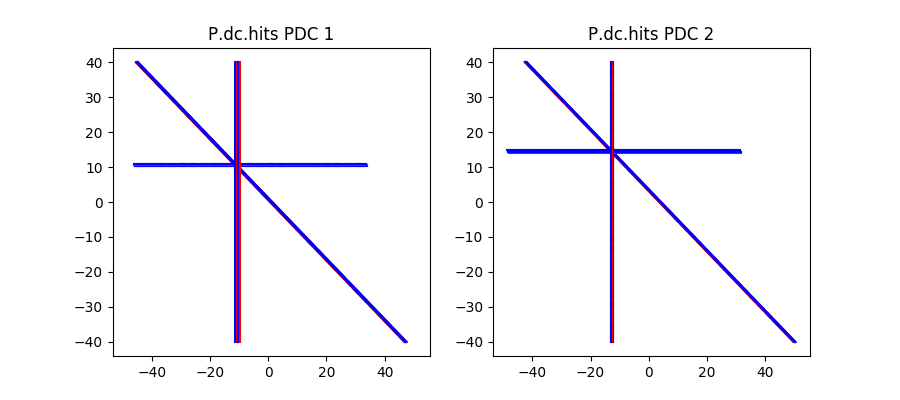

In [7]:
shear = True

t = 0  # change this value to plot different tracks

fig_dim = 4  # size of figures in inches?
fig = plt.figure( figsize=(2.25 * fig_dim, fig_dim) )

ax1 = plt.subplot(1,2,1)
plt.title( h[:-1] + ' PDC 1')
for hit in h_tracks_1[t]:
    line = shms.hit_to_2d(hit, half_plane=0, shear=shear)
    plt.plot(line[0], line[1], 'k--')
    line = shms.hit_to_2d(hit, half_plane=1, shear=shear)
    plt.plot(line[0], line[1], 'r')
    line = shms.hit_to_2d(hit, half_plane=-1, shear=shear)
    plt.plot(line[0], line[1], 'b')

ax2 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1)
plt.title( h[:-1] + ' PDC 2')
for hit in h_tracks_2[t]:
    line = shms.hit_to_2d(hit, half_plane=0, shear=shear)
    plt.plot(line[0], line[1], 'k--')
    line = shms.hit_to_2d(hit, half_plane=1, shear=shear)
    plt.plot(line[0], line[1], 'r')
    line = shms.hit_to_2d(hit, half_plane=-1, shear=shear)
    plt.plot(line[0], line[1], 'b')

plt.show()

In [8]:
def track_to_heatmap(track, res=80):
    """Function to compute a (square) heatmap of a cost function.
    res = resolution of heatmap; track_to_heatmap() will create a square, 2d grid with total of res^2 pixels
    """
    
    lines = [hit_to_2d(hit) for hit in track]
    times = [time_to_dist(hit[1]) for hit in track]
    
    res = int(res)  # make sure resolution is an integer
    
    heatmap = np.zeros((res, res))
    
    for i in range(res):
        for j in range(res):
            point = ( j*(PDC.pcbwidth / res) - (PDC.pcbwidth / 2) + 1/2,
                     -i*(PDC.pcbheight / res) + (PDC.pcbheight / 2) - 1/2)
            
            tot_cost = sum(abs(times[k] - point_line_dist(point, lines[k])) for k in range(len(track)))
            heatmap[i][j] = tot_cost
    
    return heatmap

Demonstration of
* hit-locating algorithm and
* heatmap cost function visulaization.

<IPython.core.display.Javascript object>


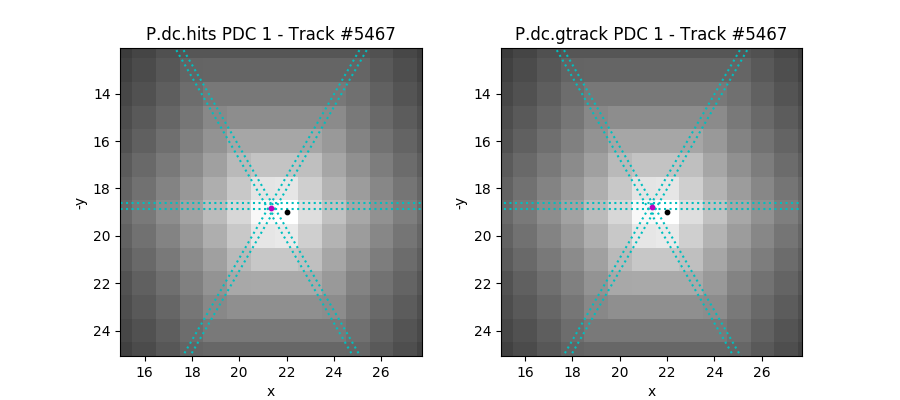

In [22]:
t = 5467  # change this value to plot different tracks

fig_dim = 4
fig = plt.figure( figsize=(2.25*fig_dim, fig_dim) )

# Compute cost heatmaps
res = 40  # running time of track_to_heatmap() scales as Theta(res^2)
h_heatmap = shms.track_to_heatmap(h_tracks_1[t], res=res)
h_min_point = (np.argmin(h_heatmap) % res, np.argmin(h_heatmap) // res)

g_heatmap = shms.track_to_heatmap(g_tracks_1[t], res=res)
g_min_point = (np.argmin(g_heatmap) % res, np.argmin(g_heatmap) // res)

# Compute hit locations
h_hit_pos = shms.track_to_2d_pos(h_tracks_1[t])
g_hit_pos = shms.track_to_2d_pos(g_tracks_1[t])
h_hit_pos = (tuple((x + PDC.pcbwidth/2)*(res/PDC.pcbwidth) - 1/2 for x in (h_hit_pos[0],)),
             tuple((-y + PDC.pcbheight/2)*(res/PDC.pcbheight) - 1/2 for y in (h_hit_pos[1],)))
g_hit_pos = (tuple((x + PDC.pcbwidth/2)*(res/PDC.pcbwidth) - 1/2 for x in (g_hit_pos[0],)),
             tuple((-y + PDC.pcbheight/2)*(res/PDC.pcbheight) - 1/2 for y in (g_hit_pos[1],)))


ax1 = plt.subplot(121)
plt.title(h[:-1] + ' PDC 1 - Track #' + str(t))
plt.xlabel('x')
plt.ylabel('-y')
# Plot wire hits
for hit in h_tracks_1[t]:
    line = shms.hit_to_2d(hit)
    # Transform lines from global coordinates to heatmap image coordinates
    line = (tuple((x + PDC.pcbwidth/2)*(res/PDC.pcbwidth) - 1/2 for x in line[0]),
            tuple((-y + PDC.pcbheight/2)*(res/PDC.pcbheight) - 1/2 for y in line[1]))
    plt.plot(line[0], line[1], 'c:')
    # Plot cost function heatmap image
plt.imshow(1 - np.exp(-h_heatmap/50), cmap='binary')  # apply a transformation to the heatmap values and show as image
# Plot minimum-cost point on heatmap
plt.scatter(h_min_point[0], h_min_point[1], c='k', s=10, zorder=10000)
plt.scatter(h_hit_pos[0], h_hit_pos[1], c='m', s=10, zorder=10001)


ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plt.title(g[:-1] + ' PDC 1 - Track #' + str(t))
plt.xlabel('x')
plt.ylabel('-y')
# Plot wire hits
for hit in g_tracks_1[t]:
    line = shms.hit_to_2d(hit)
    # Transform lines from global coordinates to heatmap image coordinates
    line = (tuple((x + PDC.pcbwidth/2)*(res/PDC.pcbwidth) - 1/2 for x in line[0]),
            tuple((-y + PDC.pcbheight/2)*(res/PDC.pcbheight) - 1/2 for y in line[1]))
    plt.plot(line[0], line[1], 'c:')
# Plot cost function heatmap image
plt.imshow(1 - np.exp(-g_heatmap/50), cmap='binary')  # apply a transformation to the heatmap values and show as image
# Plot minimum-cost point on heatmap
plt.scatter(g_min_point[0], g_min_point[1], c='k', s=10, zorder=10000)
plt.scatter(g_hit_pos[0], g_hit_pos[1], c='m', s=10, zorder=10001)


plt.show()

# More data visualization ideas

<IPython.core.display.Javascript object>


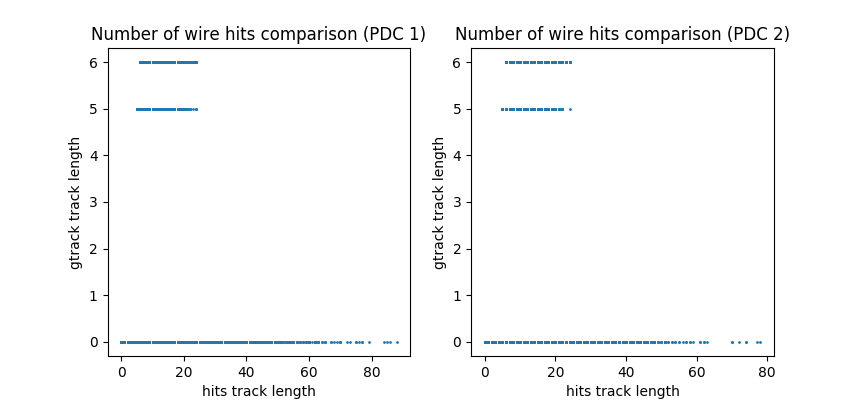

In [10]:
fig_dim = 4
fig = plt.figure( figsize=(2.15*fig_dim, fig_dim) )

plt.subplot(121)
plt.scatter([len(track) for track in h_tracks_1], [len(track) for track in g_tracks_1], s=1)
plt.title('Number of wire hits comparison (PDC 1)')
plt.xlabel('hits track length')
plt.ylabel('gtrack track length')

plt.subplot(122)
plt.scatter([len(track) for track in h_tracks_2], [len(track) for track in g_tracks_2], s=1)
plt.title('Number of wire hits comparison (PDC 2)')
plt.xlabel('hits track length')
plt.ylabel('gtrack track length')

plt.show()

### Interesting bi-modal distribution of drift times...

<IPython.core.display.Javascript object>


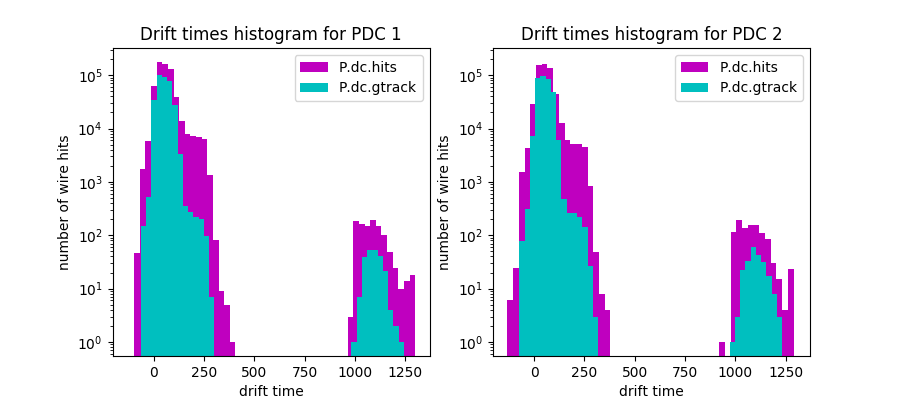

In [11]:
fig_dim = 4
fig = plt.figure( figsize=(2.25*fig_dim, fig_dim) )

ax1 = plt.subplot(121)
plt.hist([hit[1] for track in h_tracks_1 for hit in track], bins=50, log=True, color='m', label=h[:-1])
plt.hist([hit[1] for track in g_tracks_1 for hit in track], bins=50, log=True, color='c', label=g[:-1])
plt.title('Drift times histogram for PDC 1')
plt.xlabel('drift time')
plt.ylabel('number of wire hits')
plt.legend()

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plt.hist([hit[1] for track in h_tracks_2 for hit in track], bins=50, log=True, color='m', label=h[:-1])
plt.hist([hit[1] for track in g_tracks_2 for hit in track], bins=50, log=True, color='c', label=g[:-1])
plt.title('Drift times histogram for PDC 2')
plt.xlabel('drift time')
plt.ylabel('number of wire hits')
plt.legend()

plt.show()

### Wire hit distributions for each wire chamber

<IPython.core.display.Javascript object>


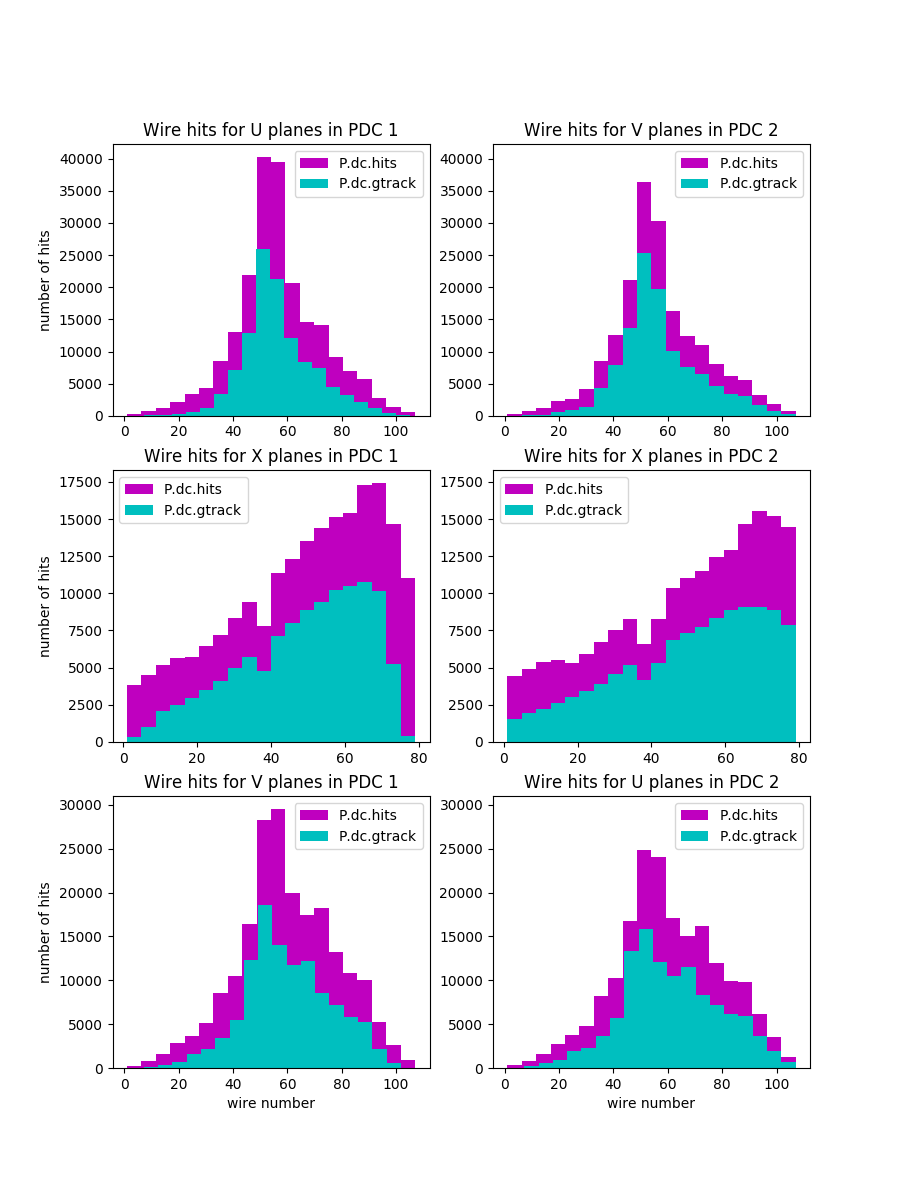

In [12]:
log = False
fig_dim = 4
fig = plt.figure( figsize=(2.25*fig_dim, 3*fig_dim) )

num_bins = 20

ax1 = plt.subplot(321)
plt.hist([hit[2] for track in h_tracks_1 for hit in track if hit[0] < 3], bins=num_bins, log=log, color='m', label=h[:-1])
plt.hist([hit[2] for track in g_tracks_1 for hit in track if hit[0] < 3], bins=num_bins, log=log, color='c', label=g[:-1])
plt.title('Wire hits for U planes in PDC 1')
#plt.xlabel('wire number')
plt.ylabel('number of hits')
plt.legend()

ax2 = plt.subplot(322, sharex=ax1, sharey=ax1)
plt.hist([hit[2] for track in h_tracks_2 for hit in track if hit[0] > 6 and hit[0] < 9], bins=num_bins, log=log, color='m', label=h[:-1])
plt.hist([hit[2] for track in g_tracks_2 for hit in track if hit[0] > 6 and hit[0] < 9], bins=num_bins, log=log, color='c', label=g[:-1])
plt.title('Wire hits for V planes in PDC 2')
#plt.xlabel('wire number')
#plt.ylabel('number of hits')
plt.legend()


ax3 = plt.subplot(323)
plt.hist([hit[2] for track in h_tracks_1 for hit in track if hit[0] > 2 and hit[0] < 5], bins=num_bins, log=log, color='m', label=h[:-1])
plt.hist([hit[2] for track in g_tracks_1 for hit in track if hit[0] > 2 and hit[0] < 5], bins=num_bins, log=log, color='c', label=g[:-1])
plt.title('Wire hits for X planes in PDC 1')
#plt.xlabel('wire number')
plt.ylabel('number of hits')
plt.legend()

ax4 = plt.subplot(324, sharex=ax3, sharey=ax3)
plt.hist([hit[2] for track in h_tracks_2 for hit in track if hit[0] > 8 and hit[0] < 11], bins=num_bins, log=log, color='m', label=h[:-1])
plt.hist([hit[2] for track in g_tracks_2 for hit in track if hit[0] > 8 and hit[0] < 11], bins=num_bins, log=log, color='c', label=g[:-1])
plt.title('Wire hits for X planes in PDC 2')
#plt.xlabel('wire number')
#plt.ylabel('number of hits')
plt.legend()


ax5 = plt.subplot(325)
plt.hist([hit[2] for track in h_tracks_1 for hit in track if hit[0] > 4 and hit[0] < 7], bins=num_bins, log=log, color='m', label=h[:-1])
plt.hist([hit[2] for track in g_tracks_1 for hit in track if hit[0] > 4 and hit[0] < 7], bins=num_bins, log=log, color='c', label=g[:-1])
plt.title('Wire hits for V planes in PDC 1')
plt.xlabel('wire number')
plt.ylabel('number of hits')
plt.legend()

ax6 = plt.subplot(326, sharex=ax5, sharey=ax5)
plt.hist([hit[2] for track in h_tracks_2 for hit in track if hit[0] > 10], bins=num_bins, log=log, color='m', label=h[:-1])
plt.hist([hit[2] for track in g_tracks_2 for hit in track if hit[0] > 10], bins=num_bins, log=log, color='c', label=g[:-1])
plt.title('Wire hits for U planes in PDC 2')
plt.xlabel('wire number')
#plt.ylabel('number of hits')
plt.legend()

plt.show()

### 3D distribution of hit attributes

In [13]:
hx1 = [hit[0] for track in h_tracks_1 for hit in track]
hy1 = [hit[1] for track in h_tracks_1 for hit in track]
hz1 = [hit[2] for track in h_tracks_1 for hit in track]

gx1 = [hit[0] for track in g_tracks_1 for hit in track]
gy1 = [hit[1] for track in g_tracks_1 for hit in track]
gz1 = [hit[2] for track in g_tracks_1 for hit in track]

hx2 = [hit[0] for track in h_tracks_2 for hit in track]
hy2 = [hit[1] for track in h_tracks_2 for hit in track]
hz2 = [hit[2] for track in h_tracks_2 for hit in track]

gx2 = [hit[0] for track in g_tracks_2 for hit in track]
gy2 = [hit[1] for track in g_tracks_2 for hit in track]
gz2 = [hit[2] for track in g_tracks_2 for hit in track]

<IPython.core.display.Javascript object>


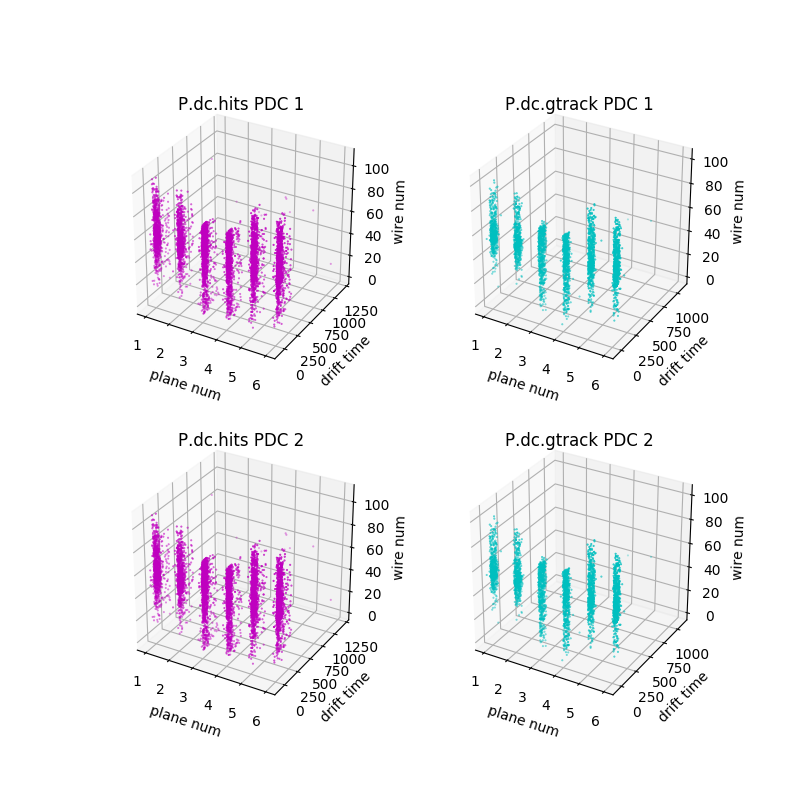

In [14]:
showaxis = True
antialias = True
skip = round(10 ** 2)  # plot only a portion of the total number of points

fig_dim = 8
fig = plt.figure( figsize=(fig_dim, fig_dim) )

ax1 = fig.add_subplot(221, projection='3d')
ax1.set_title(h[:-1] + ' PDC 1')
ax1.set_xlabel('plane num')
ax1.set_ylabel('drift time')
ax1.set_zlabel('wire num')
ax1.scatter(hx1[::skip], hy1[::skip], hz1[::skip], s=0.25, c='m', antialiased=antialias)
if not showaxis:
    ax1.set_axis_off()
else:
    ax1.set_axis_on()

ax2 = fig.add_subplot(222, projection='3d')
ax2.set_title(g[:-1] + ' PDC 1')
ax2.set_xlabel('plane num')
ax2.set_ylabel('drift time')
ax2.set_zlabel('wire num')
ax2.scatter(gx1[::skip], gy1[::skip], gz1[::skip], s=0.25, c='c', antialiased=antialias)
if not showaxis:
    ax2.set_axis_off()
else:
    ax2.set_axis_on()

ax3 = fig.add_subplot(223, projection='3d')
ax3.set_title(h[:-1] + ' PDC 2')
ax3.set_xlabel('plane num')
ax3.set_ylabel('drift time')
ax3.set_zlabel('wire num')
ax3.scatter(hx1[::skip], hy1[::skip], hz1[::skip], s=0.25, c='m', antialiased=antialias)
if not showaxis:
    ax3.set_axis_off()
else:
    ax3.set_axis_on()

ax4 = fig.add_subplot(224, projection='3d')
ax4.set_title(g[:-1] + ' PDC 2')
ax4.set_xlabel('plane num')
ax4.set_ylabel('drift time')
ax4.set_zlabel('wire num')
ax4.scatter(gx1[::skip], gy1[::skip], gz1[::skip], s=0.25, c='c', antialiased=antialias)
if not showaxis:
    ax4.set_axis_off()
else:
    ax4.set_axis_on()

plt.show()

### Distribution of wire number differences between primed and unprimed planes

In [15]:
# Collect all tracks which have a hit in each plane
g_tracks_full = [track for track in g_tracks if not (False in [(j in [int(i) for i in list(track.transpose()[0])]) for j in range(1,13)])]

In [16]:
t = 0
track = g_tracks_full[t]

planes = [hit[0] for hit in track]
wirenums = [hit[1] for hit in track]

i = 6

print(track)
wirenums[np.where(i == track[:,0])[0][0]] - wirenums[np.where(i+6 == track[:,0])[0][0]]

[[  1.          46.28069215  53.        ]
 [  3.          17.71070515  30.        ]
 [  4.          75.81968615  29.        ]
 [  5.           6.76716115  45.        ]
 [  6.         130.98489815  44.        ]
 [  2.          55.35049315  53.        ]
 [  7.          58.13493215  50.        ]
 [  9.          58.94037715  25.        ]
 [ 10.          50.53994215  26.        ]
 [ 11.          41.28331215  43.        ]
 [ 12.          56.82827415  43.        ]
 [  8.          59.89393315  51.        ]]


74.15662399999987

In [17]:
# Calculate wirenumber differences for each corresponding plane
wirenum_diffs = np.zeros((len(g_tracks_full), 6))

for j, track in enumerate(g_tracks_full):
    planes = [hit[0] for hit in track]
    wirenums = [hit[1] for hit in track]
    for i in range(1,7):
        
        if (i in planes) and (2*i in planes):
            wirenum_diffs[j][i-1] = wirenums[np.where(i == track[:,0])[0][0]] - wirenums[np.where(((-i - 1 + 12) % 12) == track[:,0])[0][0]]
        else:
            wirenum_diffs[j][i-1] = np.nan

In [18]:
wirenum_diffs[0:5]

array([[-4.25925000e+00, -3.58988400e+00, -4.21832280e+01,
         1.76847540e+01, -1.24217737e+02,  1.24217737e+02],
       [ 2.78838230e+01,  5.30669200e+00,  5.94083000e+01,
        -5.50363300e+01, -7.68691340e+01,  7.68691340e+01],
       [ 2.74075000e+00, -5.18988400e+00,  1.69708300e+01,
         1.17550000e-01, -7.82341090e+01,  7.82341090e+01],
       [-3.99453370e+01,  3.98847110e+01, -5.01996860e+01,
         3.28662450e+01, -4.18177370e+01,  4.18177370e+01],
       [-6.01617700e+00,  5.41144200e+00,  3.22708300e+01,
        -2.47824500e+01,  6.54658910e+01, -6.54658910e+01]])

In [19]:
g_tracks_full[0]

array([[  1.        ,  46.28069215,  53.        ],
       [  3.        ,  17.71070515,  30.        ],
       [  4.        ,  75.81968615,  29.        ],
       [  5.        ,   6.76716115,  45.        ],
       [  6.        , 130.98489815,  44.        ],
       [  2.        ,  55.35049315,  53.        ],
       [  7.        ,  58.13493215,  50.        ],
       [  9.        ,  58.94037715,  25.        ],
       [ 10.        ,  50.53994215,  26.        ],
       [ 11.        ,  41.28331215,  43.        ],
       [ 12.        ,  56.82827415,  43.        ],
       [  8.        ,  59.89393315,  51.        ]])

<IPython.core.display.Javascript object>


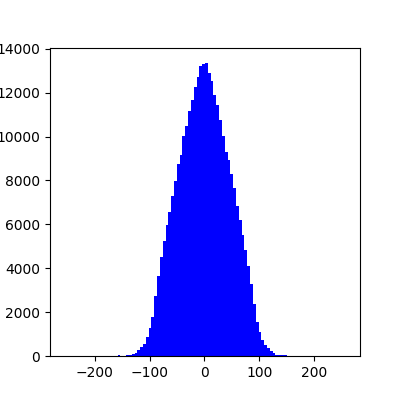

In [20]:
fig_dim = 4
fig = plt.figure( figsize=(fig_dim, fig_dim) )

plt.hist(wirenum_diffs.flatten(), bins=100, log=False, color='b')

plt.show()